## Importing the Dependencies 📚

Let's start with importing the necessary dependencies for our analysis and model building process. 🚀

In [1]:
import os

import time

import random

import itertools

from PIL import Image

#--------------------------------------------------------------------------------------#

import numpy as np

import pandas as pd

#--------------------------------------------------------------------------------------#

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

#--------------------------------------------------------------------------------------#

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#--------------------------------------------------------------------------------------#

import tensorflow as tf

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Input, Dense, Dropout

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#--------------------------------------------------------------------------------------#

print(f'Tensorflow Version: {tf.__version__}')

print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

#--------------------------------------------------------------------------------------#

import warnings

warnings.filterwarnings("ignore")

2024-04-24 04:49:25.703826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 04:49:25.703931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 04:49:25.828939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.15.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Visualization and Preprocessing 📊

In [2]:
# helper functions

#--------------------------------------------------------------------------------------#

def data_appender(data, path, folder):
    folderpath = os.path.join(path, folder)
    files = os.listdir(folderpath)
    
    for file in files:
        filepath = os.path.join(folderpath, file)
        data['imgpath'].append(filepath)
        data['labels'].append(folder)
    
    return data

#--------------------------------------------------------------------------------------#

def dataset_splitter(dataset, train_size = 0.9, test_size = 0.5, shuffle = True, random_state = 0):
    train_df, temp_df = train_test_split(dataset, train_size = train_size, 
                                         shuffle = shuffle, random_state = random_state)
    
    val_df, test_df = train_test_split(temp_df, test_size = test_size, 
                                       shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    test_df = test_df.reset_index(drop = True)
    
    return train_df, val_df, test_df

#--------------------------------------------------------------------------------------#

## Organizing the Images 📂

Let's begin by organizing the images into a dataset that we'll be working with. 📊

In [3]:
data = {'imgpath': [], 'labels': []}
path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
folders = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

for folder in folders:
    data = data_appender(data = data, path = path, folder = folder)

dataset = pd.DataFrame(data)
dataset.head()

,imgpath,labels
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio


## Exploratory Visualizations 📊

In this section, we'll explore various visualizations to gain insights into our dataset. 📈

### Visualizing Random Images 🔍

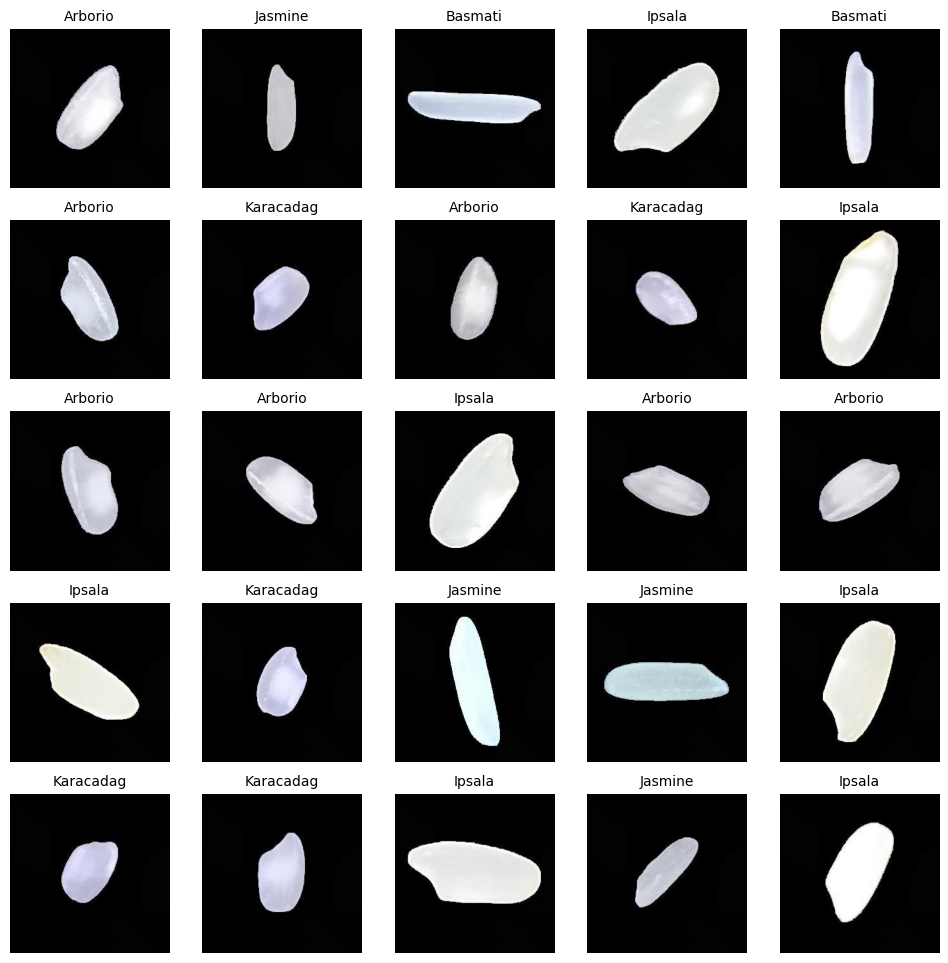

In [4]:
rows = 5
cols = 5

selected_indices = random.sample(range(len(dataset)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = dataset['imgpath'].iloc[idx]
    label = dataset['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

### Distribution of Labels 📊

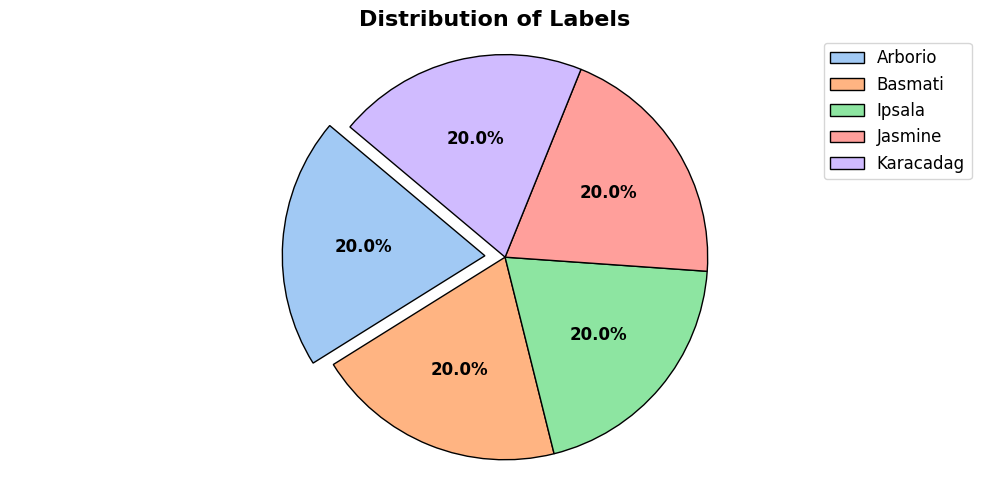

In [5]:
fig, ax = plt.subplots(figsize = (10, 5))

labels = dataset['labels'].value_counts().index
sizes = dataset['labels'].value_counts().values
colors = sns.color_palette('pastel')

wedges, texts, autotexts = ax.pie(sizes, colors = colors, 
                                  autopct = '%1.1f%%', startangle = 140, 
                                  explode = (0.1, 0, 0, 0, 0), wedgeprops = dict(edgecolor = 'black'))

ax.set_title('Distribution of Labels', fontsize = 16, fontweight = 'bold')
ax.axis('equal') 
ax.legend(wedges, labels, loc = "best", fontsize = 12)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## Data Pre-Processing 🧪

In this section, we'll preprocess our data to prepare it for model training. 📝


In [6]:
train_df, val_df, test_df = dataset_splitter(dataset)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}')


Training Dataframe of shape (67500, 2): 
                                             imgpath   labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Basmati
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Jasmine
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...   Ipsala
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio

Validation Dataframe of shape (3750, 2): 
                                             imgpath     labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Basmati
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Basmati
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Arborio

Testing Dataframe of shape (3750, 2): 
                                             imgpath     labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...   

In [7]:
%%time

seed = 0
batch_size = 128
img_size = (224, 224)

generator = ImageDataGenerator(rescale = 1./255)

train_data = generator.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels', 
                                           color_mode = 'rgb', class_mode = 'categorical', 
                                           batch_size = batch_size, target_size = img_size, 
                                           shuffle = True, seed = seed)

val_data = generator.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels', 
                                         color_mode = 'rgb', class_mode = 'categorical', 
                                         batch_size = batch_size, target_size = img_size, 
                                         shuffle = False)

test_data = generator.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels', 
                                          color_mode = 'rgb', class_mode = 'categorical', 
                                          batch_size = batch_size, target_size = img_size, 
                                          shuffle = False)

Found 67500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
CPU times: user 1.15 s, sys: 1.9 s, total: 3.05 s
Wall time: 1min 38s


# Creating and Training the Classifier 🛠️

 this section, we'll develop and train our classification model for rice grain classification. 📈

## Creating the Classifier 🤖

In [8]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', 
                       input_shape = img_size + (3,), pooling = 'max')

for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
model = Sequential([
    Input(shape = img_size + (3,), name = 'input_layer'),
    base_model,
    
    Dense(512, activation = 'relu'),
    Dropout(0.4, seed = seed),
    
    Dense(256, activation = 'relu'),
    Dropout(0.4, seed = seed),
    
    Dense(len(set(train_data.classes)), activation = 'softmax', name = 'output_layer')
])

model.compile(optimizer = Adam(learning_rate = 0.001), 
              loss = CategoricalCrossentropy(), metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,046,469 (11.62 MB)

 Trainable params: 788,485 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training the Classifier 🎓

In [10]:
%%time

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

history = model.fit(train_data, validation_data = val_data, 
                    epochs = 10, callbacks = [model_es, model_rlr])

Epoch 1/10
  2/528 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.1914 - loss: 7.8733   

I0000 00:00:1713934309.708348     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713934309.752056     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


528/528 ━━━━━━━━━━━━━━━━━━━━ 617s 1s/step - accuracy: 0.8751 - loss: 0.6337 - val_accuracy: 0.9845 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 165s 308ms/step - accuracy: 0.9741 - loss: 0.0798 - val_accuracy: 0.9829 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 167s 312ms/step - accuracy: 0.9850 - loss: 0.0465 - val_accuracy: 0.9872 - val_loss: 0.0375 - learning_rate: 2.0000e-04
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 167s 312ms/step - accuracy: 0.9875 - loss: 0.0400 - val_accuracy: 0.9885 - val_loss: 0.0328 - learning_rate: 2.0000e-04
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 165s 309ms/step - accuracy: 0.9885 - loss: 0.0362 - val_accuracy: 0.9885 - val_loss: 0.0340 - learning_rate: 2.0000e-04
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 166s 310ms/step - accuracy: 0.9913 - loss: 0.0299 - val_accuracy: 0.9899 - val_loss: 0.0298 - learning_rate: 4.0000e-05
Epoch 7/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 167s 312ms/step - accu

# Evaluating the Classifier 📏

In this section, we'll assess the performance of our email classification model. 📈

In [11]:
test_results = model.evaluate(test_data, verbose = 0)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

Test Loss: 0.02237
Test Accuracy: 99.25%


In [12]:
class_labels = list(train_data.class_indices.keys())

test_classes = test_data.classes
predicted_classes = np.argmax(model.predict(test_data, verbose = 0), axis = 1)

print(f'Classification Report (Test) --> \n\n' + \
f'{classification_report(test_classes, predicted_classes, target_names = class_labels)}')

Classification Report (Test) --> 

              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99       768
     Basmati       0.99      0.99      0.99       678
      Ipsala       1.00      1.00      1.00       763
     Jasmine       0.99      0.99      0.99       754
   Karacadag       0.99      1.00      0.99       787

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



## Evaluation Visualization 📊

Here, we'll visualize the evaluation metrics to gain insights into our classifier's performance. 📈

### Accuracy and Loss Curve 📈

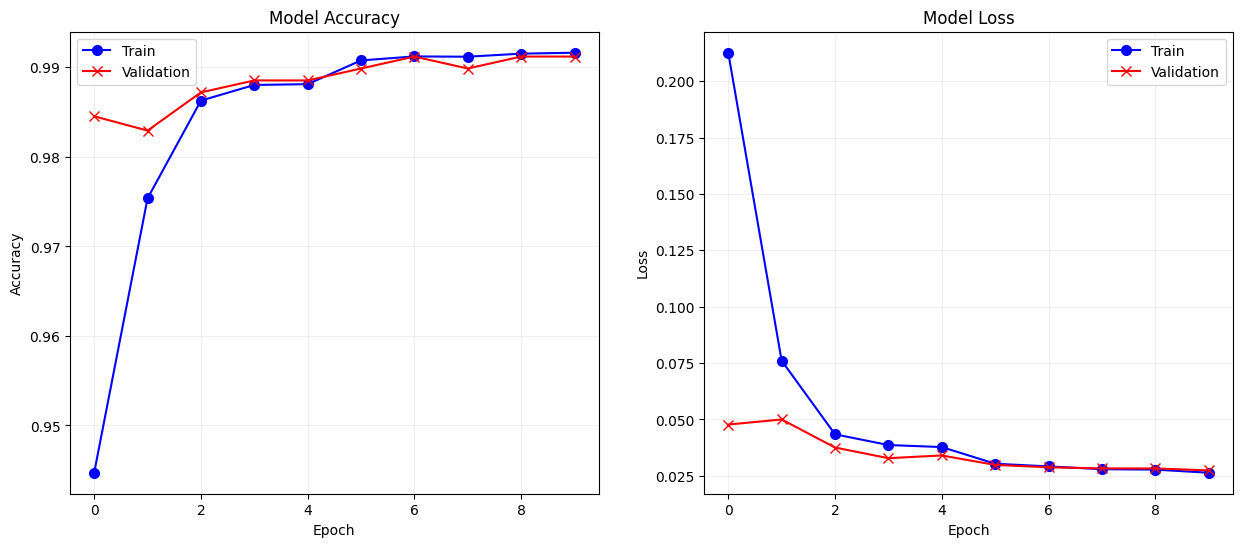

In [13]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# accuracy

ax[0].plot(history.history['accuracy'], marker = 'o', color = 'blue', markersize = 7)
ax[0].plot(history.history['val_accuracy'], marker = 'x', color = 'red', markersize = 7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha = 0.2)

# loss

ax[1].plot(history.history['loss'], marker = 'o', color = 'blue', markersize = 7)
ax[1].plot(history.history['val_loss'], marker = 'x', color = 'red', markersize = 7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha = 0.2)

plt.show()

### Confusion Matrix 📊

<Figure size 1000x1000 with 0 Axes>

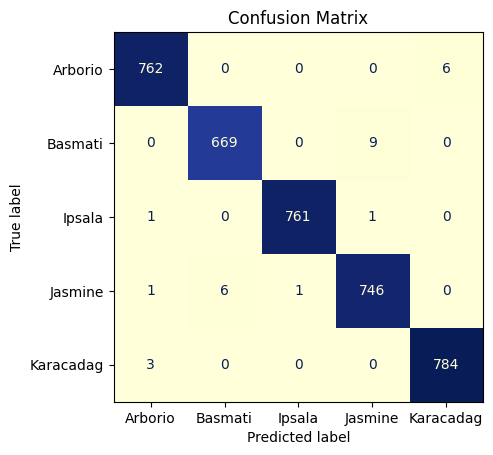

In [14]:
test_matrix = confusion_matrix(test_classes, predicted_classes)

class_labels = list(test_data.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')

plt.show()

**Thank you for reviewing my notebook! If you found it helpful, I'd appreciate an upvote.** 😄